In [2]:
from mnist_c import corruptions

x = 1

corruptions.identity(x)


perturbation_matrix = [  ]

array(1., dtype=float32)

In [59]:
from torchvision import datasets, transforms
import torch
import numpy as np

def get_stream(data, blackbox, horizon, outcome_distribution, m, s):
    
    sample = np.random.randint(0, len(data), horizon) #np.random.permutation( range(horizon) )
    datastream = DataStream( horizon, sample, m, s)
    stream = datastream.random_stream(  data, blackbox, list(  outcome_distribution.values() ) )
    # stream = datastream.secretary_stream( data, blackbox, 25, 10, True )
    return stream

device = torch.device("cpu") #"cuda:0" if torch.cuda.is_available() else  

horizon = 10

data = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor() )


perturbation_rate = 0.1
n =1000
attack = 0
no_attack = 0
for d in data:

    if np.random.uniform( 0,1 ) <= perturbation_rate:
        attack+=1


    else:
        no_attack+=1

print(   attack/n, no_attack/n)



gaussian_noise(x, severity=5)
shot_noise(x, severity=5)
impulse_noise(x, severity=4)
speckle_noise(x, severity=5)
pessimal_noise(x, severity=1)
gaussian_blur(x, severity=2)
glass_blur(x, severity=1)
defocus_blur(x, severity=1)
motion_blur(x, severity=1)
zoom_blur(x, severity=5)
fog(x, severity=5)
frost(x, severity=5)
snow(x, severity=5)
spatter(x, severity=4)
contrast(x, severity=4)
brightness(x, severity=5)
saturate(x, severity=5)
pixelate(x, severity=3)
shear(x, severity=2)


    # print(d[0], d[1])



# X_train = [  d[0]   for d in data_train ]
# X_train = torch.stack(X_train)



# m = X_train.mean(0, keepdim=True).to(device)
# s = X_train.std(0, unbiased=False, keepdim=True).to(device)
# sample = np.random.randint(0, len(data), horizon) 
# datastream = DataStream( horizon, sample, m, s)


# stream = datastream.random_stream(  data, blackbox, list(  outcome_distribution.values() ) )


# stream = get_stream( data, blackbox_model, horizon, outcome_distribution, m, s )

0.097 0.903


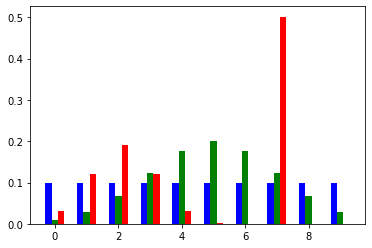

In [41]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt


def gaussian_distribution(loc, scale):
    loc = 5
    scale = 2
    x = np.arange(0, 10)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, loc=loc, scale=scale) - ss.norm.cdf(xL, loc=loc, scale=scale)
    prob = prob / prob.sum() # normalize the probabilities so their sum is 1
    return prob


def multinomial_distribution(loc1, scale1, loc2, scale2):
    loc = 5
    scale = 2
    x = np.arange(0, 10)
    xU, xL = x + 0.5, x - 0.5 
    prob1 = ss.norm.cdf(xU, loc=loc1, scale=scale1) - ss.norm.cdf(xL, loc=loc1, scale=scale1)
    prob2 = ss.norm.cdf(xU, loc=loc2, scale=scale2) - ss.norm.cdf(xL, loc=loc2, scale=scale2)

    prob = prob1+prob2 
    prob = prob / prob.sum() # normalize the probabilities so their sum is 1
    return prob


x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

perturbation_rate = 0.2
n_classes = 10

y = np.ones( n_classes) / n_classes
z = gaussian_distribution(5, 2)
k = multinomial_distribution(2, 1, 7, 0.1)

ax = plt.subplot(111)
ax.bar(x-0.2, y, width=0.2, color='b', align='center')
ax.bar(x, z, width=0.2, color='g', align='center')
ax.bar(x+0.2, k, width=0.2, color='r', align='center')

plt.show()

In [ ]:
class DataStream:

    def __init__(self, horizon, sample, m, s):
        self.horizon = horizon #nombre de timesteps
        self.sample = sample #longueur du stream d'images considere (je crois)
        self.m = m #moyenne des pixels, cela est fait pour eviter des bugs
        self.s = s # variance des pixels, cela est fait pour eviter des bugs
        self.R = {} #cela est detaille dans le papier ICLR2022, algo 1
        self.Sa = [] #cela est detaille dans le papier ICLR2022, algo 1

    def random_stream(self, data, blackbox, outcome_distribution ):

        stream = []
        label = []
        outcomes = []
        for i, idx, in enumerate(self.sample) :
            outcome = np.random.choice( [1, 0], p=outcome_distribution)
            X,y =  data[idx]

            X = X.reshape( (1,1,28,28) ).to(device)
            # zero mask
            mask = (self.s != 0)

            # finally perform division
            X[mask] = X[mask] / self.s[mask]

            X -= self.m
            print(X)
            y = torch.Tensor([ y ]).type(torch.LongTensor).to(device)
            if outcome==1:
                delta = attacks.pgd_linf(blackbox, X , y).to(device)
                X = X + delta
            stream.append(  X[0] )
            label.append(y)
            outcomes.append([outcome])

        stream = torch.stack(stream).to('cpu').detach() 
        label = torch.stack(label).to('cpu').detach() 
        status = torch.Tensor(outcomes).to('cpu').detach() 
        
        return  TensorDataset( stream, label, status ) 

    def virtual_plus(self, i, v_i, t, k, exhaust):

        outcome = 0

        if i <= t: # sampling phase
            self.R[i] = v_i
            self.R = { k: v for k, v in sorted(self.R.items(), key=lambda item: item[1]) }
            
        else: # selection phase
            last_value = list( self.R.values() )[-1]
            last_key = list( self.R.keys() )[-1]
            num_left_to_pick = k - len(self.Sa) 
            num_samples_left = self.horizon - i
            if  num_samples_left <= num_left_to_pick and exhaust and num_left_to_pick > 0:
                self.Sa.append(i)
                outcome = 1

            if v_i >= last_value and len(self.Sa) <= k:
                del self.R[ last_key ]
                self.R[i] = v_i
                self.R = {k: v for k, v in sorted(self.R.items(), key=lambda item: item[1])}
                self.Sa.append(i)
                outcome = 1

        return outcome

    def secretary_stream(self, data, blackbox, t, k, exhaust):

        stream = []
        label = []
        outcomes = []

        for i, idx, in enumerate(self.sample) : 

            X, y =  data[idx]
            X = X.reshape( (1,1,28,28) ).to(device)
            y = torch.Tensor([ y ]).type(torch.LongTensor).to(device)

            delta = attacks.pgd_linf(blackbox, X , y).to(device)
            X_prime = X + delta
            v_i = nn.CrossEntropyLoss()( blackbox(X_prime) ,y)

            outcome = self.virtual_plus( i, v_i, t, k, exhaust)

            stream.append(  X[0]  )
            label.append(y )
            outcomes.append([outcome])

        stream = torch.stack(stream).to('cpu').detach().numpy()
        label = torch.stack(label).to('cpu').detach().numpy()
        status = torch.Tensor(outcomes).to('cpu').detach().numpy()
        #
        return  TensorDataset( stream, label, status ) 


# blackbox_model = blackbox.load()
# mnist_val = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor() )
# datastream = DataStream()
# # random_stream = datastream.random_stream( mnist_val, blackbox_model, [0.5,0.5] )
# sec_stream = datastream.secretary_stream( mnist_val, blackbox_model  )